# Plot of computational time

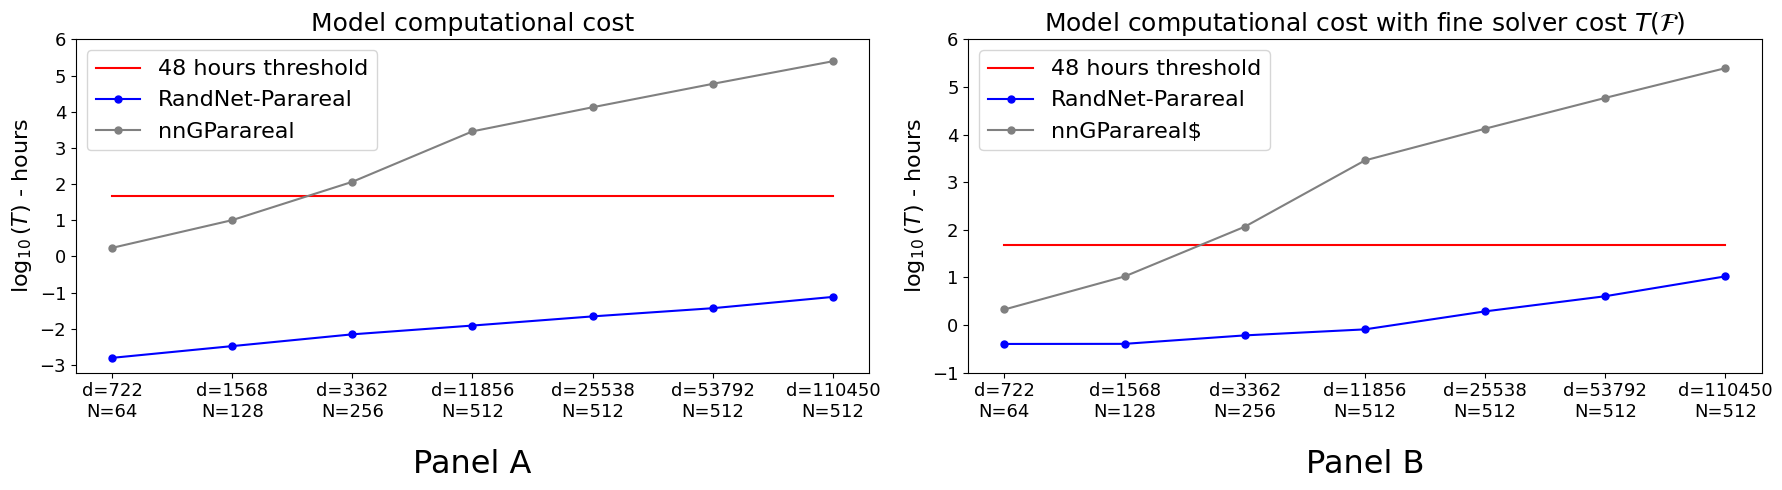

In [7]:
#%%
# 
import numpy as np
import matplotlib.pyplot as plt

# First Figure
m = 20
k = [16, 20, 50, 100, 100, 100, 100]
N = [64, 128, 256, 512, 512, 512, 512]
d = [722, 1568, 3362, 11856, 25538, 53792, 110450]

T = []
for i in range(7):
    T.append(k[i] * N[i] * max(d[i] / N[i], 1) * (m**2.8 + m**2 + d[i] * (m**2 + 2 * m) + m * np.log(N[i] * k[i])))

M = 100
k = [12, 12, 12, 6, 5, 4, 4]
T1 = []
n = 4
for i in range(7):
    T1.append(k[i] * N[i] * (M**2.8 + M**2 * n + d[i] * (M**2 + 3 * M * n) + n * np.log(N[i] * k[i])) / N[i])



fontsize = 16
fs_ticks = 13


fig, axs = plt.subplots(1,2,figsize=(18,5))
ax1 = axs[0]
ax1.plot(np.log10(48) * np.ones(7), label='48 hours threshold', color="red")
ax1.plot(np.log10(np.array(T1) / 3600 / 600000 / 30), '-o',label='RandNet-Parareal', color="blue", markersize=5)
ax1.plot(np.log10(np.array(T) / 3600 / 600000), '-o', label='nnGParareal', color="gray", markersize=5)
ax1.set_xlabel('Panel A', fontsize=fontsize+7, labelpad=20)
ax1.set_ylabel(r'$\log_{10}(T)$ - hours', fontsize=fontsize)

row1 = ['d=722', 'd=1568', 'd=3362', 'd=11856', 'd=25538', 'd=53792', 'd=110450']
row2 = ['N=64', 'N=128', 'N=256', 'N=512', 'N=512', 'N=512', 'N=512']
tickLabels = [f'{r1}\n{r2}' for r1, r2 in zip(row1, row2)]
ax1.set_xticks(range(len(d)), tickLabels)
ax1.set_yticks(np.arange(-3, 7))
ax1.tick_params(axis='both', labelsize=fs_ticks)
ax1.legend(loc='best', fontsize=fontsize)
ax1.set_title('Model computational cost', fontsize=fontsize+2)

#%

# Second Figure
f = [2*60, 2*60, 3*60, 8*60, 23*60, 60*60, 2*3600+37*60]


f_nngp = []
for i in range(7):
    # T[i] = k[i] * N[i] * max(d[i] / N[i], 1) * (m**2.8 + m**2 + d[i] * (m**2 + 2 * m) + m * np.log(N[i] * k[i]))
    f_nngp.append(k[i] * f[i])

# T1 = []
f_randNet = []
for i in range(7):
    # T1.append(k[i] * N[i] * (M**2.8 + M**2 * n + d[i] * (M**2 + 3 * M * n) + n * np.log(N[i] * k[i])) / N[i])
    f_randNet.append(k[i] * f[i])


ax2 = axs[1]
ax2.plot(np.log10(48) * np.ones(7), label='48 hours threshold', color="red")
ax2.plot(np.log10(np.array(f_randNet) / 3600 + np.array(T1) / 3600 / 600000 / 30), '-o', label='RandNet-Parareal', color="blue", markersize=5)
ax2.plot(np.log10(np.array(f_nngp) / 3600 + np.array(T) / 3600 / 600000), '-o', label='nnGParareal$', color="gray", markersize=5)
ax2.set_xlabel('Panel B', fontsize=fontsize+7, labelpad=20)
ax2.set_ylabel(r'$\log_{10}(T)$ - hours', fontsize=fontsize)
ax2.set_yticks(np.arange(-1, 7))
ax2.set_xticks(range(len(d)), tickLabels)
ax2.legend(loc='best', fontsize=fontsize)
ax2.tick_params(axis='both', labelsize=fs_ticks)
ax2.set_title(r'Model computational cost with fine solver cost $T(\mathcal{F})$', fontsize=fontsize+2)
fig.tight_layout()

fig.savefig('model_computational_cost.pdf')


# Brusselator

In [ ]:
#%%
from mpi4py.futures import MPIPoolExecutor
import os
import sys

print('starting')


from parareal import PararealLight
from solver import SolverAbstr
import pde
import numpy as np
import matplotlib.pyplot as plt
from systems import ODE
import time

import numba as nb


import warnings
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=LinAlgWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pde 
import numpy as np
import numba as nb
from pde.solvers.base import SolverBase
from systems import ODE
from solver import SolverAbstr

mn_u, mx_u = 0.3, 4
mn_v, mx_v = 0.8, 5

scal = 0.01
d = 20
space_size = 3

N = 235

class BrusselatorPDE(pde.PDEBase):
    """Brusselator with diffusive mobility."""

    def __init__(self, a=1, b=3, diffusivity=[1, 0.1], bc="auto_periodic_neumann", rng=None):
        super().__init__()
        self.a = a
        self.b = b
        self.diffusivity = diffusivity  # spatial mobility
        self.bc = bc  # boundary condition
        self.rng = rng

    def get_initial_state(self, grid):
        """Prepare a useful initial state."""
        u = pde.ScalarField(grid, self.a, label="Field $u$")
        v = self.b / self.a + 0.1 * pde.ScalarField.random_normal(grid, label="Field $v$", rng=self.rng)
        return pde.FieldCollection([u, v])

    def evolution_rate(self, state, t=0):
        """Pure python implementation of the PDE."""
        u, v = state
        u = (u+1)/2 * (mx_u-mn_u) + mn_u
        v = (v+1)/2 * (mx_v-mn_v) + mn_v
        scale_u = 2/(mx_u-mn_u)
        scale_v = 2/(mx_v-mn_v)
        rhs = state.copy()
        d0, d1 = self.diffusivity
        rhs[0] = d0 * u.laplace(self.bc) + self.a - (self.b + 1) * u + u**2 * v
        rhs[1] = d1 * v.laplace(self.bc) + self.b * u - u**2 * v
        rhs[0] = scale_u * rhs[0] * scal
        rhs[1] = scale_v * rhs[1] * scal
        return rhs

    def _make_pde_rhs_numba(self, state):
        """Nunmba-compiled implementation of the PDE."""
        d0, d1 = self.diffusivity
        a, b = self.a, self.b
        laplace = state.grid.make_operator("laplace", bc=self.bc)

        @nb.njit
        def pde_rhs(state_data, t):
            u = state_data[0]
            v = state_data[1]
            u = (u+1)/2 * (mx_u-mn_u) + mn_u
            v = (v+1)/2 * (mx_v-mn_v) + mn_v
            scale_u = 2/(mx_u-mn_u)
            scale_v = 2/(mx_v-mn_v)

            rate = np.empty_like(state_data)
            rate[0] = scale_u * (d0 * laplace(u) + a - (1 + b) * u + v * u**2) * scal
            rate[1] = scale_v * (d1 * laplace(v) + b * u - v * u**2) * scal
            return rate

        return pde_rhs
        
class CstmExplicitSolver(pde.ExplicitSolver):
    name = 'explicit_mine'
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _make_single_step_fixed_euler(self, state):
        if self.pde.is_sde:
            # handle stochastic version of the pde
            raise Exception('NOt implemented 1')

        else:
            # handle deterministic version of the pde
            rhs_pde = self._make_pde_rhs(state, backend=self.backend)

            def stepper(state_data: np.ndarray, t: float, dt) -> None:
                """perform a single Euler step"""
                state_data += dt * rhs_pde(state_data, t)

        return stepper

    def _make_single_step_rk45(self, state):
        if self.pde.is_sde:
            raise RuntimeError("Runge-Kutta stepper does not support stochasticity")

        # obtain functions determining how the PDE is evolved
        rhs = self._make_pde_rhs(state, backend=self.backend)

        def stepper(state_data: np.ndarray, t: float, dt) -> None:
            """compiled inner loop for speed"""
            # calculate the intermediate values in Runge-Kutta
            k1 = dt * rhs(state_data, t)
            k2 = dt * rhs(state_data + 0.5 * k1, t + 0.5 * dt)
            k3 = dt * rhs(state_data + 0.5 * k2, t + 0.5 * dt)
            k4 = dt * rhs(state_data + k3, t + dt)

            state_data += (k1 + 2 * k2 + 2 * k3 + k4) / 6
        return stepper

    def _make_single_step_fixed_dt(self, state):
        
        if self.scheme == "euler":
            return self._make_single_step_fixed_euler(state)
        elif self.scheme in {"runge-kutta", "rk", "rk45"}:
            return self._make_single_step_rk45(state)
        else:
            raise ValueError(f"Explicit scheme `{self.scheme}` is not supported")
        
    def _make_fixed_stepper(self, state):
        single_step = self._make_single_step_fixed_dt(state)
        # print('before')

        if self._compiled:
            # print('compiling')
            sig_single_step = (nb.typeof(state.data), nb.double, nb.double)
            single_step = nb.jit(sig_single_step)(single_step)

        def fixed_stepper(
            state_data: np.ndarray, t_start: float, steps: int, dt
        ):
            """perform `steps` steps with fixed time steps"""
            modifications = 0.0
            for i in range(steps):
                # calculate the right hand side
                t = t_start + i * dt
                single_step(state_data, t, dt)

            return t + dt

        if self._compiled:
            sig_fixed = (nb.typeof(state.data), nb.double, nb.int_, nb.double)
            fixed_stepper = nb.jit(sig_fixed)(fixed_stepper)

        return fixed_stepper

    def make_stepper(self, state):
        fixed_stepper = self._make_fixed_stepper(state)
        return fixed_stepper

class CstmController():

    def __init__(self, t_range, stepper, tracker=None):
        self.wrapped_stepper = stepper
        self.t_range = t_range

    @property
    def t_range(self) -> tuple[float, float]:
        return self._t_range

    @t_range.setter
    def t_range(self, value):
        try:
            self._t_range: tuple[float, float] = (0, float(value))  # type: ignore
        except TypeError:  # assume a single number was given
            if len(value) == 2:  # type: ignore
                self._t_range = tuple(value)  # type: ignore
            else:
                raise ValueError(
                    "t_range must be set to a single number or a tuple of two numbers"
                )

    def run(self, initial_state, dt):
        state = initial_state.copy()
        t_start, t_end = self.t_range

        # initialize the stepper
        self.wrapped_stepper(state, t_start, t_end, dt)

        if not np.all(np.isfinite(state.data)):
            raise Exception("Field was not finite")
        return state
    
    


class KSSolver(SolverAbstr):
    def __init__(self, grid, G_step, F_step, Gdt, Fdt):
        self.grid=grid

        self.g_stepper = G_step
        self.f_stepper = F_step
        self.Gdt = Gdt
        self.Fdt = Fdt
        

    def run_G(self, t0, t1, u0):
        fields = [pde.ScalarField(self.grid, u0[i,...]) for i in range(u0.shape[0])]
        state = pde.FieldCollection(fields)
        controller = CstmController(t_range=(t0,t1), stepper=self.g_stepper)
        return controller.run(state, dt=self.Gdt).data
    
    def run_F(self, t0, t1, u0):
        fields = [pde.ScalarField(self.grid, u0[i,...]) for i in range(u0.shape[0])]
        state = pde.FieldCollection(fields)
        controller = CstmController(t_range=(t0,t1), stepper=self.f_stepper)
        return controller.run(state, dt=self.Fdt).data
    
class KSODE(ODE):
    def __init__(self, d, space_size, u0):
        self.name = 'Brus'
        self.d = d
        self.space_size = space_size
        self.u0 = u0

    def get_init_cond(self):
        return self.u0
    
    def get_dim(self):
        return self.u0.shape
        


class PararealLightMod(PararealLight):
    def run(self, *args, **kwargs):
        pool = self._get_pool(*args, **kwargs)
        kwargs['pool'] = pool
        if kwargs.get('_run_from_int', False):
            out = self._run_from_int(*args, **kwargs)
        else:
            out = self._run(*args, **kwargs)
        return out

        





rng = np.random.default_rng(2345)
eq = BrusselatorPDE(rng=rng)
grid = pde.UnitGrid([d]*space_size, periodic=[True]*space_size)  

state = eq.get_initial_state(grid)
init_cond = state.data
init_cond[0,...] = 2*(init_cond[0,...]-mn_u)/(mx_u-mn_u)-1
init_cond[1,...] = 2*(init_cond[1,...]-mn_v)/(mx_v-mn_v)-1

F = CstmExplicitSolver(eq, scheme='rk', backend='numba')
G = CstmExplicitSolver(eq, scheme='euler', backend='numba')

F_fixed_stepper = F.make_stepper(pde.FieldCollection([pde.ScalarField(grid),pde.ScalarField(grid)]))
G_fixed_stepper = G.make_stepper(pde.FieldCollection([pde.ScalarField(grid),pde.ScalarField(grid)]))
def F_wrapped_stepper(state, t_start: float, t_end: float, Fdt) -> float:
    steps = max(1, int(np.ceil((t_end - t_start) / Fdt)))
    return F_fixed_stepper(state.data, t_start, steps, Fdt)

def G_wrapped_stepper(state, t_start: float, t_end: float, Gdt) -> float:
    steps = max(1, int(np.ceil((t_end - t_start) / Gdt)))
    return G_fixed_stepper(state.data, t_start, steps, Gdt)

#%

import json

def store_l(l):
    # return None
    try:
        with open('revision_Brus3.txt', 'a') as f:
            f.write(json.dumps(l)+'\n')
    except Exception as e:
        pass

def do(pool, inp):
    Gdt, T = inp
    Fdt = 0.001
    solver = KSSolver(grid, G_step=G_wrapped_stepper, F_step=F_wrapped_stepper, Gdt=Gdt, Fdt=Fdt)

    ode = KSODE(d, space_size, init_cond.copy()) 
    
    p = PararealLightMod(ode, solver, (0, T), N, epsilon=5e-7)

    l = [scal, d, space_size, Gdt, T, N, Fdt]
    try:
        res_elm = p.run(model='elm', degree=1, m=4,pool=pool, parall='mpi', light=True)
        l.extend(('elm', res_elm['k']))
    except Exception as e:
        l.extend(('elm', -1, str(e)))
        print(l)
        store_l(l)  
        return

    try:
        res = p.run(pool=pool, parall='mpi', light=True)
        l.extend(['para', res['k'], res_elm['timings'], res['timings']])
        print(l)
        store_l(l)
    except Exception as e:
        l.extend(['para', -1, str(e), res_elm['timings']])
        store_l(l)
        print(l)
        return
        


if __name__ == '__main__':
    
    avail_work = int(os.getenv('SLURM_NTASKS'))
    workers = avail_work - 1
    print('Total workes', workers)
    pool = MPIPoolExecutor(workers)

    from itertools import product, repeat

    T = [20, 21, 22,25, 30, 35, 40, 45, 50, 55, 60,61,62, 65,70, 100,101,102,105, 150, 155, 200,201,202, 250, 300]
    Gdt = 10**(np.linspace(0,-3, 50))
    args = list(product(Gdt, T))

    print(len(args))

    np.random.seed(34)
    args = np.random.permutation(args)

    out = list(map(do, repeat(pool), args))


# from IPython.display import clear_output
# from matplotlib import pyplot as plt

# l = [init_cond.copy()]
# for i in range(20):
#     l.append(solver.run_F(i,i+1,l[-1]))
#     plt.imshow(l[-1][0,...])
#     plt.title(i)
#     clear_output(wait=True)
#     plt.pause(0.1)

## Run Scal

In [ ]:

from mpi4py.futures import MPIPoolExecutor
import pickle
from configs import Config
from systems import FHN_PDE, DiffReact
from solver import SolverRK, SolverScipy
from parareal import PararealLight
import numpy as np
import os
import sys

from parareal import PararealLight
from solver import SolverAbstr
import pde
import numpy as np
import matplotlib.pyplot as plt
from systems import ODE
import time

import numba as nb


import warnings
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=LinAlgWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pde 
import numpy as np
import numba as nb
from pde.solvers.base import SolverBase
from systems import ODE
from solver import SolverAbstr


# print(sys.argv, sys.argv[-3:])
mdl, d = sys.argv[-2:] 
d = int(d)

T = 35

mn_u, mx_u = 0.3, 4
mn_v, mx_v = 0.8, 5

scal = 0.01
N = 512
Fdt = 1e-7


if d == 20:
    space_size = 3
    Gdt = 0.052
elif d == 25:
    space_size = 3
    Gdt = 0.057
elif d == 32:
    space_size = 2
    Gdt = 0.034
elif d == 64:
    space_size = 2
    Gdt = 0.033
else:
    raise Exception('Invalid dx val')
                          

class BrusselatorPDE(pde.PDEBase):
    """Brusselator with diffusive mobility."""

    def __init__(self, a=1, b=3, diffusivity=[1, 0.1], bc="auto_periodic_neumann", rng=None):
        super().__init__()
        self.a = a
        self.b = b
        self.diffusivity = diffusivity  # spatial mobility
        self.bc = bc  # boundary condition
        self.rng = rng

    def get_initial_state(self, grid):
        """Prepare a useful initial state."""
        u = pde.ScalarField(grid, self.a, label="Field $u$")
        v = self.b / self.a + 0.1 * pde.ScalarField.random_normal(grid, label="Field $v$", rng=self.rng)
        return pde.FieldCollection([u, v])

    def evolution_rate(self, state, t=0):
        """Pure python implementation of the PDE."""
        u, v = state
        u = (u+1)/2 * (mx_u-mn_u) + mn_u
        v = (v+1)/2 * (mx_v-mn_v) + mn_v
        scale_u = 2/(mx_u-mn_u)
        scale_v = 2/(mx_v-mn_v)
        rhs = state.copy()
        d0, d1 = self.diffusivity
        rhs[0] = d0 * u.laplace(self.bc) + self.a - (self.b + 1) * u + u**2 * v
        rhs[1] = d1 * v.laplace(self.bc) + self.b * u - u**2 * v
        rhs[0] = scale_u * rhs[0] * scal
        rhs[1] = scale_v * rhs[1] * scal
        return rhs

    def _make_pde_rhs_numba(self, state):
        """Nunmba-compiled implementation of the PDE."""
        d0, d1 = self.diffusivity
        a, b = self.a, self.b
        laplace = state.grid.make_operator("laplace", bc=self.bc)

        @nb.njit
        def pde_rhs(state_data, t):
            u = state_data[0]
            v = state_data[1]
            u = (u+1)/2 * (mx_u-mn_u) + mn_u
            v = (v+1)/2 * (mx_v-mn_v) + mn_v
            scale_u = 2/(mx_u-mn_u)
            scale_v = 2/(mx_v-mn_v)

            rate = np.empty_like(state_data)
            rate[0] = scale_u * (d0 * laplace(u) + a - (1 + b) * u + v * u**2) * scal
            rate[1] = scale_v * (d1 * laplace(v) + b * u - v * u**2) * scal
            return rate

        return pde_rhs
        
class CstmExplicitSolver(pde.ExplicitSolver):
    name = 'explicit_mine'
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _make_single_step_fixed_euler(self, state):
        if self.pde.is_sde:
            # handle stochastic version of the pde
            raise Exception('NOt implemented 1')

        else:
            # handle deterministic version of the pde
            rhs_pde = self._make_pde_rhs(state, backend=self.backend)

            def stepper(state_data: np.ndarray, t: float, dt) -> None:
                """perform a single Euler step"""
                state_data += dt * rhs_pde(state_data, t)

        return stepper

    def _make_single_step_rk45(self, state):
        if self.pde.is_sde:
            raise RuntimeError("Runge-Kutta stepper does not support stochasticity")

        # obtain functions determining how the PDE is evolved
        rhs = self._make_pde_rhs(state, backend=self.backend)

        def stepper(state_data: np.ndarray, t: float, dt) -> None:
            """compiled inner loop for speed"""
            # calculate the intermediate values in Runge-Kutta
            k1 = dt * rhs(state_data, t)
            k2 = dt * rhs(state_data + 0.5 * k1, t + 0.5 * dt)
            k3 = dt * rhs(state_data + 0.5 * k2, t + 0.5 * dt)
            k4 = dt * rhs(state_data + k3, t + dt)

            state_data += (k1 + 2 * k2 + 2 * k3 + k4) / 6
        return stepper

    def _make_single_step_fixed_dt(self, state):
        
        if self.scheme == "euler":
            return self._make_single_step_fixed_euler(state)
        elif self.scheme in {"runge-kutta", "rk", "rk45"}:
            return self._make_single_step_rk45(state)
        else:
            raise ValueError(f"Explicit scheme `{self.scheme}` is not supported")
        
    def _make_fixed_stepper(self, state):
        single_step = self._make_single_step_fixed_dt(state)
        # print('before')

        if self._compiled:
            # print('compiling')
            sig_single_step = (nb.typeof(state.data), nb.double, nb.double)
            single_step = nb.jit(sig_single_step)(single_step)

        def fixed_stepper(
            state_data: np.ndarray, t_start: float, steps: int, dt
        ):
            """perform `steps` steps with fixed time steps"""
            modifications = 0.0
            for i in range(steps):
                # calculate the right hand side
                t = t_start + i * dt
                single_step(state_data, t, dt)

            return t + dt

        if self._compiled:
            sig_fixed = (nb.typeof(state.data), nb.double, nb.int_, nb.double)
            fixed_stepper = nb.jit(sig_fixed)(fixed_stepper)

        return fixed_stepper

    def make_stepper(self, state):
        fixed_stepper = self._make_fixed_stepper(state)
        return fixed_stepper

class CstmController():

    def __init__(self, t_range, stepper, tracker=None):
        self.wrapped_stepper = stepper
        self.t_range = t_range

    @property
    def t_range(self) -> tuple[float, float]:
        return self._t_range

    @t_range.setter
    def t_range(self, value):
        try:
            self._t_range: tuple[float, float] = (0, float(value))  # type: ignore
        except TypeError:  # assume a single number was given
            if len(value) == 2:  # type: ignore
                self._t_range = tuple(value)  # type: ignore
            else:
                raise ValueError(
                    "t_range must be set to a single number or a tuple of two numbers"
                )

    def run(self, initial_state, dt):
        state = initial_state.copy()
        t_start, t_end = self.t_range

        # initialize the stepper
        self.wrapped_stepper(state, t_start, t_end, dt)

        if not np.all(np.isfinite(state.data)):
            raise Exception("Field was not finite")
        return state
    
    


class KSSolver(SolverAbstr):
    def __init__(self, grid, G_step, F_step, Gdt, Fdt):
        self.grid=grid

        self.g_stepper = G_step
        self.f_stepper = F_step
        self.Gdt = Gdt
        self.Fdt = Fdt
        

    def run_G(self, t0, t1, u0):
        fields = [pde.ScalarField(self.grid, u0[i,...]) for i in range(u0.shape[0])]
        state = pde.FieldCollection(fields)
        controller = CstmController(t_range=(t0,t1), stepper=self.g_stepper)
        return controller.run(state, dt=self.Gdt).data
    
    def run_F(self, t0, t1, u0):
        fields = [pde.ScalarField(self.grid, u0[i,...]) for i in range(u0.shape[0])]
        state = pde.FieldCollection(fields)
        controller = CstmController(t_range=(t0,t1), stepper=self.f_stepper)
        return controller.run(state, dt=self.Fdt).data
    
class KSODE(ODE):
    def __init__(self, d, space_size, u0):
        self.name = 'Brus'
        self.d = d
        self.space_size = space_size
        self.u0 = u0

    def get_init_cond(self):
        return self.u0
    
    def get_dim(self):
        return self.u0.shape
        


class PararealLightMod(PararealLight):
    def run(self, *args, **kwargs):
        pool = self._get_pool(*args, **kwargs)
        kwargs['pool'] = pool
        if kwargs.get('_run_from_int', False):
            out = self._run_from_int(*args, **kwargs)
        else:
            out = self._run(*args, **kwargs)
        return out
    
    def _parareal(self, model, early_stop=None, parall='Serial', store_int=False, light=False, **kwargs):
        tspan, N, epsilon, n = self.tspan, self.N, self.epsilon, self.n
        u0 = self.u0
        solver: SolverAbstr = self.solver

        if kwargs.get('debug', False):
            print('WARNING: PararealLight does not support debug mode')
                         
        t = np.linspace(tspan[0], tspan[1], num=N+1)           
        I = 0                             
            
        parall = parall.lower()
        if parall == 'mpi':
            if 'pool' not in kwargs:
                raise Exception('MPI parallel backend requested but no pool of worker provided')
            pool = kwargs['pool']
            
        if 'verbose' in kwargs:
            verbose = kwargs['verbose']
        else:
            verbose = self.verbose

        if verbose and parall != 'serial':
            print(f'Running {model.name} with {parall} parallel backend')
            
        conv_int = []
        
        # u = np.empty((N+1, n, N+1))
        # uG = np.empty((N+1, n, N+1))
        # uF = np.empty((N+1, n, N+1))
        err = np.empty((N+1, N))
        # u.fill(np.nan)
        # uG.fill(np.nan)
        # uF.fill(np.nan)
        err.fill(np.nan)

        # err_old = np.empty((N+1, N))
        # err_old.fill(np.nan)

        u_curr = np.empty((N+1, *n))
        u_next = np.empty((N+1, *n))
        uG_curr = np.empty((N+1, *n))
        uG_next = np.empty((N+1, *n))
        uF_curr = np.empty((N+1, *n))
        uF_next = np.empty((N+1, *n))
        u_curr.fill(np.nan)
        u_next.fill(np.nan)
        uG_curr.fill(np.nan)
        uG_next.fill(np.nan)
        uF_curr.fill(np.nan)
        uF_next.fill(np.nan)
        
        # x_old = np.zeros((0, n))
        # D_old = np.zeros((0,n))
        x = np.zeros((0, np.prod(n)))
        D = np.zeros((0, np.prod(n)))
        
        G_time = 0
        F_time = 0
        F_time_serial = 0
        
            
        # u[0,:,:] = u0[:, np.newaxis]
        # uG[0,:,:] = u[0,:,:]
        # uF[0,:,:] = u[0,:,:]

        u_curr[0,...] = u0
        uG_curr[0,...] = u_curr[0,...]
        uF_curr[0,...] = u_curr[0,...]
        u_next[0,...] = u_curr[0,...]
        uG_next[0,...] = u_curr[0,...]
        uF_next[0,...] = u_curr[0,...]
        
        
        # Initialization: run G sequentially
        temp = u0
        for i in range(N):
            temp, temp_t = solver.run_G_timed(t[i], t[i+1], temp)
            G_time += temp_t
            # uG[i+1,:,0] = temp
            uG_curr[i+1,...] = temp

        del temp, temp_t
        # u[:,:,0] = uG[:,:,0]
        u_curr[:,...] = uG_curr[:,...]

        
        #Step 2: integrate using F (fine solver) in parallel with the current best initial
        # values
        for k in range(N):
            if verbose == 'v':
                print(f'{self.ode_name} {model.name} iteration number (out of {N}): {k+1} ')
                
            s_time = time.time()
            if parall == 'mpi':
                out = list(pool.map(solver.run_F_timed, t[I:N], t[I+1:N+1], [u_curr[i,...] for i in range(I,N)]))
                _temp_uFs = np.array([i[0] for i in out])
                uF_curr[I+1:N+1,...] = _temp_uFs
                F_time_serial += np.array([i[1] for i in out]).mean()
                del _temp_uFs
            elif parall == 'joblib':
                out = Parallel(-1)(delayed(lambda i: solver.run_F_timed(t[i], t[i+1], u_curr[i,...]))(i) for i in range(I,N))
                _temp_uFs = np.array([i[0] for i in out])
                uF_curr[I+1:N+1,...] = _temp_uFs
                F_time_serial += np.array([i[1] for i in out]).mean()
            else:
                temp_t = 0
                for i in range(I, N):
                    # temp_old = solver.run_F_timed(t[i], t[i+1], u[i,:,k])
                    temp, _temp_t_int = solver.run_F_timed(t[i], t[i+1], u_curr[i,...])
                    # uF[i+1,:,k] = temp_old[0]
                    uF_curr[i+1,...] = temp
                    temp_t += _temp_t_int
                F_time_serial += temp_t/(N-I)
            F_time += time.time() - s_time
            del s_time
            # save values forward (as solution at time I+1 is now converged)

            uG_next[I+1,...] = uG_curr[I+1,...]
            uF_next[I+1,...] = uF_curr[I+1,...]
            u_next[I+1,...] = uF_curr[I+1,...]
            I = I + 1
            # collect training data
            x_to_add = u_curr[I-1:N+1-1,...]
            D_to_add = uF_curr[I:N+1,...] - uG_curr[I:N+1,...]
            x = np.vstack([x, x_to_add.reshape(x_to_add.shape[0], np.prod(x_to_add.shape[1:]), order='C')])
            D = np.vstack([D, D_to_add.reshape(D_to_add.shape[0], np.prod(D_to_add.shape[1:]), order='C')])
            
            
            # early stop if only one interval was missing
            if I == N:
                if verbose == 'v':
                    print('WARNING: early stopping')
                err_old = np.nextafter(epsilon, 0)
                err[:,k] = np.array(list(map(lambda x: np.linalg.norm(x.ravel(), np.inf), (u_next - u_curr))))
                err[-1,k] = np.nextafter(epsilon, 0)
                break
            
            
            model.fit_timed(x, D, k=k)
                
            for i in range(I, N):

                

                # run G solver on best initial value
                temp, temp_t = solver.run_G_timed(t[i], t[i+1], u_next[i,...])
                G_time += temp_t
                uG_next[i+1,...] = temp
                del temp, temp_t
                
                mdl_inpt = u_next[i,...].reshape(1,-1, order='C')
                # preds = model.predict_timed(u_next[i,...].reshape(1,-1), 
                #                             uF_curr[i+1,...], uG_curr[i+1,...], i=i)

                _start_time_ = time.time()
                preds = model.predict_timed(mdl_inpt, 
                                            uF_curr[i+1,...], uG_curr[i+1,...], i=i)
                print(f'Done update {i-I} of {N-I} in {time.time()-_start_time_}s')
                preds = preds.reshape(*n, order='C')
                
                
                # do predictor-corrector update
                # u[i+1,:,k+1] = uF[i+1,:,k] + uG[i+1,:,k+1] - uG[i+1,:,k]
                u_next[i+1,...] = preds + uG_next[i+1,...]
                
            
            # error catch
            a = 0
            if np.any(np.isnan(uG_next[:,...])):
                raise Exception("NaN values in initial coarse solve - increase Ng!")
            # if np.any(np.isnan(uG[:,:, k+1])):
            #     raise Exception("NaN values in initial coarse solve - increase Ng!")
                           
            # Step 4: Converence check
            # checks whether difference between solutions at successive iterations
            # are small, if so then that time slice is considered converged. 
                          
            # err_old[:,k] = np.linalg.norm(u[:,:,k+1] - u[:,:,k], np.inf, 1)
            # err_old[I,k] = 0

            err[:,k] = np.array(list(map(lambda x: np.linalg.norm(x.ravel(), np.inf), (u_next - u_curr))))
            # err[:,k] = np.linalg.norm(u_next[:,...] - u_curr[:,...], np.inf, 1)
            err[I,k] = 0
            

            u_curr[...] = u_next[...]
            uG_curr[...] = uG_next[...]
            II = I
            for p in range(II+1, N+1):
                if err[p, k] < epsilon:
                    u_next[p,...] = u_curr[p,...]
                    uG_next[p,...] = uG_curr[p,...]
                    uF_next[p,...] = uF_curr[p,...]
                    I += 1
                else:
                    break
            uF_curr[...] = uF_next[...]


            if verbose == 'v':    
                print('--> Converged:', I)
            conv_int.append(I)
            if store_int:
                raise NotImplementedError('PararealLight does not support storing intermediate results')
                # name_base = f'{self.ode_name}_{self.N}_{model.name}_int'
                # int_dir = kwargs.get('int_dir', '')
                # name_base = kwargs.get('int_name', name_base)
                # int_name = f'{name_base}_{k}'
                # _objs = {'t':t, 'I':I, 'verbose':verbose,
                #      'u':u[...,:k+2], 'uG':uG[...,:k+2], 'uF':uF[...,:k+2], 'err':err[...,:k+2], 'x':x, 'D':D, 
                #      'G_time':G_time, 'F_time':F_time,
                #      'early_stop':early_stop, 'parall':parall, 'store_int':store_int, 'kwargs':kwargs,
                #      'k':k, 'conv_int': conv_int}
                
                # self.store(path=os.path.join(int_dir, name_base), name=int_name, mdl=model, objs=_objs)
                
                
            if I == N:
                break
            if (early_stop is not None) and k == (early_stop-1):
                if verbose == 'v':
                    print('Early stopping due to user condition.')
                break
        
        debug_dict = {}
            
            
        timings = {'F_time':F_time, 'G_time': G_time, 'F_time_serial_avg': F_time_serial/(k+1)}
        timings.update(model.get_times())
        
        # return {'t':t, 'u':u[:,:,:k+1], 'err':err[:, :k+1], 'x':x, 'D':D, 'k':k+1, 
        #         'u_curr':u_curr, 'uG_curr':uG_curr, 'uF_curr':uF_curr, 'err_old':err_old[:,:k+1],
        #         'uF':uF[:,:,:k+1], 'uG':uG[:,:,:k+1], 'x_old':x_old, 'D_old':D_old,
        #         'timings':timings, 'debug_dict':debug_dict, 'converged':I==N, 
        #         'conv_int':conv_int}

        if light:
            if 'by_iter' in timings:
                timings.pop('by_iter')
            return {'t':t, 'u':u_curr, 'err':err[:, :k+1], 'k':k+1, 
                'timings':timings, 'debug_dict':debug_dict, 'converged':I==N, 
                'conv_int':conv_int}
        else:
            return {'t':t, 'u':u_curr, 'err':err[:, :k+1], 'x':x, 'D':D, 'k':k+1, 
                'timings':timings, 'debug_dict':debug_dict, 'converged':I==N, 
                'conv_int':conv_int}



rng = np.random.default_rng(2345)
eq = BrusselatorPDE(rng=rng)
grid = pde.UnitGrid([d]*space_size, periodic=[True]*space_size)  

state = eq.get_initial_state(grid)
init_cond = state.data
init_cond[0,...] = 2*(init_cond[0,...]-mn_u)/(mx_u-mn_u)-1
init_cond[1,...] = 2*(init_cond[1,...]-mn_v)/(mx_v-mn_v)-1

F = CstmExplicitSolver(eq, scheme='rk', backend='numba')
G = CstmExplicitSolver(eq, scheme='euler', backend='numba')

F_fixed_stepper = F.make_stepper(pde.FieldCollection([pde.ScalarField(grid),pde.ScalarField(grid)]))
G_fixed_stepper = G.make_stepper(pde.FieldCollection([pde.ScalarField(grid),pde.ScalarField(grid)]))
def F_wrapped_stepper(state, t_start: float, t_end: float, Fdt) -> float:
    steps = max(1, int(np.ceil((t_end - t_start) / Fdt)))
    return F_fixed_stepper(state.data, t_start, steps, Fdt)

def G_wrapped_stepper(state, t_start: float, t_end: float, Gdt) -> float:
    steps = max(1, int(np.ceil((t_end - t_start) / Gdt)))
    return G_fixed_stepper(state.data, t_start, steps, Gdt) 


if __name__ == '__main__':
    
    avail_work = int(os.getenv('SLURM_NTASKS'))
    workers = avail_work - 1
    print('Total workes', workers)
    pool = MPIPoolExecutor(workers)
    
    # print(N, mdl, dx, ode.name)
    
    
    ########## CHANGE THIS #########
    dir_name = 'BrusPDE'
    ################################
    
    name = f'{dir_name}_{d}_{mdl}'
    # assert workers >= N
    
    # generate folder
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    
    ########## CHANGE THIS #########
        
    solver = KSSolver(grid, G_step=G_wrapped_stepper, F_step=F_wrapped_stepper, Gdt=Gdt, Fdt=Fdt)
    ode = KSODE(d, space_size, init_cond.copy()) 
    p = PararealLightMod(ode, solver, (0, T), N, epsilon=5e-7)

    # First run is biased, do one iter of Para
    res = p.run(model='elm', degree=1, m=4, pool=pool, parall='mpi', light=True, early_stop=1)
    
    #####################################
    
    # run the code, storing intermediates in custom folder
    if mdl == 'para':
        res = p.run(pool=pool, parall='mpi', light=True)
    elif mdl == 'elm':
        res = p.run(model='elm', degree=1, m=4, pool=pool, parall='mpi', light=True)
    elif mdl == 'nngp':
        res = p.run(model='nngp', pool=pool, parall='mpi', light=True, 
                    nn=20)
    else:
        raise Exception('Unknown model type', mdl)
        
    print(res['timings'])
        
    # dump the final result
    p.store(name=name, path=dir_name)

## Plots

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def calc_t(sec, full=False):
    days = sec // (24 * 3600)
    hours = (sec - days * 24 * 3600) // 3600
    minutes = (sec - days * 24 * 3600 - hours * 3600) // 60
    seconds = sec - days * 24 * 3600 - hours * 3600 - minutes * 60

    if full:
        out = f'{int(days)}d {int(hours)}h {int(minutes)}m {int(seconds)}s'
    else:
        if days > 0:
            if minutes > 30:
                hours += 1
            out = f'{int(days)}d {int(hours)}h'
        else:
            if hours > 0:
                if seconds > 30:
                    minutes += 1
                out = f'{int(hours)}h {int(minutes)}m'
            elif minutes > 0:
                if seconds > 30:
                    minutes += 1
                out = f'{int(minutes)}m'
            else:
                out = f'{int(seconds)}s'
    return out

N = 512
# using 1e-7
F_oneint_avg = np.array([11.81, 42.32, 142.64, 284.23])*5
G_time_based_on_d_K = {
    32: {2: 0.5, 7: 0.83},
    64: {2: 0.83, 7:1.42},
    20: {2: 1.35, 8: 2.79},
    25: {2: 2.2, 9: 4.86}
}
iters = {
    'para': [7,7,8,9],
    'elm': [2,2,2,2],
    'nngp': [2, 2, 2, 2],
} 

mdl_cost = {
    'para': [0.023, 0.047, 0.10, 0.18],
    'elm': [2.82, 7.8, 13.26, 27.67],
    'nngp': [26.3*512*2, 503.84*512*2, np.nan, np.nan],
} 

# runtime
store_time = {}
for mdl in ['para', 'elm', 'nngp', 'fine']:
    for idx, d in enumerate([32, 64, 20, 25]):
        dct = store_time.get(mdl, {})
        if mdl == 'fine':
            dct[d] = N*F_oneint_avg[idx]
        else:
            dct[d] = (iters[mdl][idx]*F_oneint_avg[idx]+G_time_based_on_d_K[d][iters[mdl][idx]]+mdl_cost[mdl][idx])
        store_time[mdl] = dct

# speed-up
store = {}
for mdl in ['para', 'elm', 'nngp']:
    for idx, d in enumerate([32, 64, 20, 25]):
        dct = store.get(mdl, {})
        dct[d] = store_time['fine'][d]/store_time[mdl][d]
        store[mdl] = dct

# convert inner dictionary to list
store = {k: [v[i] for i in [32, 64, 20, 25]] for k, v in store.items()}
store_time = {k: [v[i] for i in [32, 64, 20, 25]] for k, v in store_time.items()}

# # runtime pretty
# store_time_pretty = {}
# for mdl in ['para', 'elm', 'nngp', 'fine']:
#     for idx, d in enumerate([32, 64, 20, 25]):
#         dct = store_time_pretty.get(mdl, {})
#         dct[d] = calc_t(store_time[mdl][d])
#         store_time_pretty[mdl] = dct
# # store pretty -> round values
# store_pretty = {}
# for mdl in ['para', 'elm', 'nngp']:
#     for idx, d in enumerate([32, 64, 20, 25]):
#         dct = store_pretty.get(mdl, {})
#         dct[d] = round(store[mdl][d], 2)
#         store_pretty[mdl] = dct

# for i in store_time_pretty:
#     print(i, store_time_pretty[i])
# for i in store_pretty:
    # print(i, store_pretty[i])



fontsize = 15
fs_ticks = 13
ds = np.array([2*32**2, 2*64**2, 2*20**3, 2*25**3])
Ns = [2,2, 3,3]
c = {'elm':'red','para':'gray','nngp':'blue', 'fine':'black'}    
legend_tags = {'elm':'RandNet-Parareal', 'para':'Parareal', 'nngp':'nnGParareal', 'fine':'Fine solver'}
markers = {'elm':'2', 'para':'x', 'nngp':'+', 'fine':'_'}
fig, axs = plt.subplots(1,2,figsize = [6.4*2+1, 4.8])
ax=axs[0]
# fig, ax = plt.subplots()
for key, val in store.items():
    mdl = key
    x = np.log10(ds)
    y = np.array(val)  
    if mdl == 'nngp':
        ax.scatter(x, y, label=legend_tags[mdl], marker=markers[mdl], facecolors='blue', edgecolor='blue', s=300)
        # facecolor='none'
    else:
        ax.scatter(x, y, label=legend_tags[mdl], c=c[mdl], marker=markers[mdl], s=300)

    ax.set_xticks(x)
ax.scatter(x, np.array([1]*len(x)),  c='black',marker='_', label='Fine solver',s=300)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(np.array(Ns))
ax.tick_params(axis='both', labelsize=fs_ticks)
ax2.tick_params(axis='both', labelsize=fs_ticks)
ax2.set_xlabel(r"Spatial dimensions", fontsize=fontsize)
# ax.legend(prop={'size':fontsize}, loc='upper left', frameon=False, fontsize=fontsize)
ax.set_xlabel(r'$\log_{10}(d)$',fontsize=fontsize)
ax.set_ylabel('Speed-up',fontsize=fontsize)
fig.tight_layout()

ax = axs[1]
for key, val in store_time.items():
    # mdl, _ = key.split('_')
    mdl = key
    x = np.log10(ds)
    y = np.array(val)  
    y = np.log10(y/3600)
    if mdl == 'nngp':
        ax.scatter(x, y, label=legend_tags[mdl], marker=markers[mdl], facecolors='blue', edgecolor='blue', s=300)
        # facecolor='none'
    else:
        ax.scatter(x, y, label=legend_tags[mdl], c=c[mdl], marker=markers[mdl], s=300)

    ax.set_xticks(x)
# ax.scatter(x, np.array([1]*len(x)),  c='black',marker='_', label='Fine solver',s=300)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(np.array(Ns))
ax.tick_params(axis='both', labelsize=fs_ticks)
ax2.tick_params(axis='both', labelsize=fs_ticks)
ax2.set_xlabel(r"Spatial dimensions", fontsize=fontsize)
# ax.legend(prop={'size':fontsize}, loc='upper left', frameon=False, fontsize=fontsize)
ax.legend(prop={'size':fontsize}, loc='upper left', bbox_to_anchor=(1,1), frameon=False, fontsize=fontsize)
ax.set_xlabel(r'$\log_{10}(d)$',fontsize=fontsize)
ax.set_ylabel(r'Runtime (hours, $\log_{10}$)',fontsize=fontsize)
fig.suptitle(r'2D and 3D Brussellator PDE', fontsize=fontsize+2)
fig.tight_layout()


name = 'Brus_PDE_speedup_w_time'
fig.savefig(os.path.join('revision', name), bbox_inches='tight')
fig.savefig(os.path.join('revision', name+'.pdf'), bbox_inches='tight')

